In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, BatchNormalization, Input, Embedding, Dot, Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

from wordcloud import WordCloud
%matplotlib inline

## READING ANIMELIST.CSV

In [4]:
import os

In [5]:
INPUT_DIR = os.path.join("..","artifacts","raw")

In [54]:
rating_df = pd.read_csv(INPUT_DIR+"/animelist.csv" , low_memory=True,usecols=["user_id","anime_id","rating"])

In [55]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [56]:
len(rating_df)

500000

## DATA PROCESSING

In [57]:
n_ratings = rating_df["user_id"].value_counts()
rating_df = rating_df[rating_df["user_id"].isin(n_ratings[n_ratings>=20].index)].copy()

In [58]:
n_ratings.nunique()

678

In [59]:
min_rating =min(rating_df["rating"])

In [60]:
min_rating

0

In [61]:
max_rating =max(rating_df["rating"])
max_rating

10

In [62]:
avg_rating =np.mean(rating_df["rating"])
avg_rating

np.float64(4.250903633769856)

In [63]:
rating_df["rating"] = rating_df["rating"].apply(lambda x: (x-min_rating)/(max_rating-min_rating)).values.astype(np.float64)

In [64]:
rating_df.duplicated().sum()

np.int64(0)

In [65]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [66]:
user_ids = rating_df["user_id"].unique().tolist()
user2user_encoded = {x : i for i , x in enumerate(user_ids)}
user2user_decoded = {i : x for i , x in enumerate(user_ids)}
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)


In [67]:
n_users = len(user2user_encoded)

In [68]:
n_users

1385

In [69]:
anime_ids = rating_df["anime_id"].unique().tolist()
anime2anime_encoded = {x : i for i , x in enumerate(anime_ids)}
anime2anime_decoded = {i : x for i , x in enumerate(anime_ids)}
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)

In [70]:
n_anime = len(anime2anime_encoded)
n_anime

12791

In [71]:
rating_df = rating_df.sample(frac=1,random_state=43).reset_index(drop=True)
rating_df

,user_id,anime_id,rating,user,anime
0,1548,5114,0.7,1313,63
1,1596,744,0.0,1357,6947
2,1433,3667,0.0,1215,1491
3,748,9911,0.0,633,1225
4,746,2470,0.6,632,5187
...,...,...,...,...,...
499091,1246,32182,0.7,1061,242
499092,147,1579,0.8,123,947
499093,808,3503,0.8,683,402
499094,499,14527,0.9,418,1932


In [72]:
X = rating_df[["user","anime"]].values
y = rating_df["rating"]

In [73]:
test_size = 1000
train_indices = rating_df.shape[0] - test_size

In [74]:
X_train , X_test , y_train , y_test = (
    X[:train_indices],
    X[train_indices :],
    y[:train_indices],
    y[train_indices:],
)

In [75]:
len(X_train)

498096

In [76]:
len(X_test)

1000

In [77]:
type(X_test)

numpy.ndarray

In [78]:
X_train_array = [X_train[: , 0] , X_train[: ,1]]
X_test_array = [X_test[: , 0] , X_test[: ,1]]

In [79]:
type(X_test_array)

list

In [80]:
type(X_test_array[0])

numpy.ndarray

## MODEL ARCHITECTURE

In [81]:
def RecommenderNet():
    embedding_size =128

    user = Input(name="user",shape=[1])

    user_embedding = Embedding(name="user_embedding",input_dim=n_users,output_dim=embedding_size)(user)

    anime = Input(name="anime",shape=[1])

    anime_embedding = Embedding(name="anime_embedding",input_dim=n_anime,output_dim=embedding_size)(anime)

    x = Dot(name="dot_product" , normalize=True , axes=2)([user_embedding,anime_embedding])

    x = Flatten()(x)
    model = Model(inputs=[user,anime], outputs=x)
    model.compile(loss="mse", optimizer="adam", metrics=["mae","mse"])
    return model

In [82]:
model = RecommenderNet()

In [83]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    177,280 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  1,637,248 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 1)         │          0 │ dot_product[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,814,528 (6.92 MB)

 Trainable params: 1,814,528 (6.92 MB)

 Non-trainable params: 0 (0.00 B)

In [84]:
start_lr = 0.00001
min_lr = 0.0001
max_lr = 0.00005
batch_size = 10000

ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

def lrfn(epoch):
    if epoch<ramup_epochs:
        return (max_lr-start_lr)/ramup_epochs*epoch + start_lr
    elif epoch<ramup_epochs+sustain_epochs:
        return max_lr
    else:
        return (max_lr-min_lr) * exp_decay ** (epoch-ramup_epochs-sustain_epochs)+min_lr

In [85]:
lr_callback = LearningRateScheduler(lambda epoch:lrfn(epoch) , verbose=0)
checkpoint_filepath = './weights.weights.h5'

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor="val_loss",mode="min",save_best_only=True)

early_stopping = EarlyStopping(patience=3,monitor="val_loss",mode="min",restore_best_weights=True)

In [86]:
my_callbacks = [model_checkpoint,lr_callback,early_stopping]

In [87]:
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data = (X_test_array,y_test),
    callbacks=my_callbacks
)

Epoch 1/20


50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 0.3406 - mae: 0.4551 - mse: 0.3406 - val_loss: 0.3301 - val_mae: 0.4431 - val_mse: 0.3301 - learning_rate: 1.0000e-05
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.3401 - mae: 0.4547 - mse: 0.3401 - val_loss: 0.3301 - val_mae: 0.4431 - val_mse: 0.3301 - learning_rate: 1.8000e-05
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.3393 - mae: 0.4542 - mse: 0.3393 - val_loss: 0.3300 - val_mae: 0.4430 - val_mse: 0.3300 - learning_rate: 2.6000e-05
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.3382 - mae: 0.4533 - mse: 0.3382 - val_loss: 0.3300 - val_mae: 0.4430 - val_mse: 0.3300 - learning_rate: 3.4000e-05
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.3367 - mae: 0.4522 - mse: 0.3367 - val_loss: 0.3298 - val_mae: 0.4429 - val_mse: 0.3298 - learning_rate: 4.2000e-05
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.3348 - mae: 0.4508 - mse: 0.3348 - val_loss: 0.3295 - val_mae: 0.

In [88]:
model.load_weights(checkpoint_filepath)

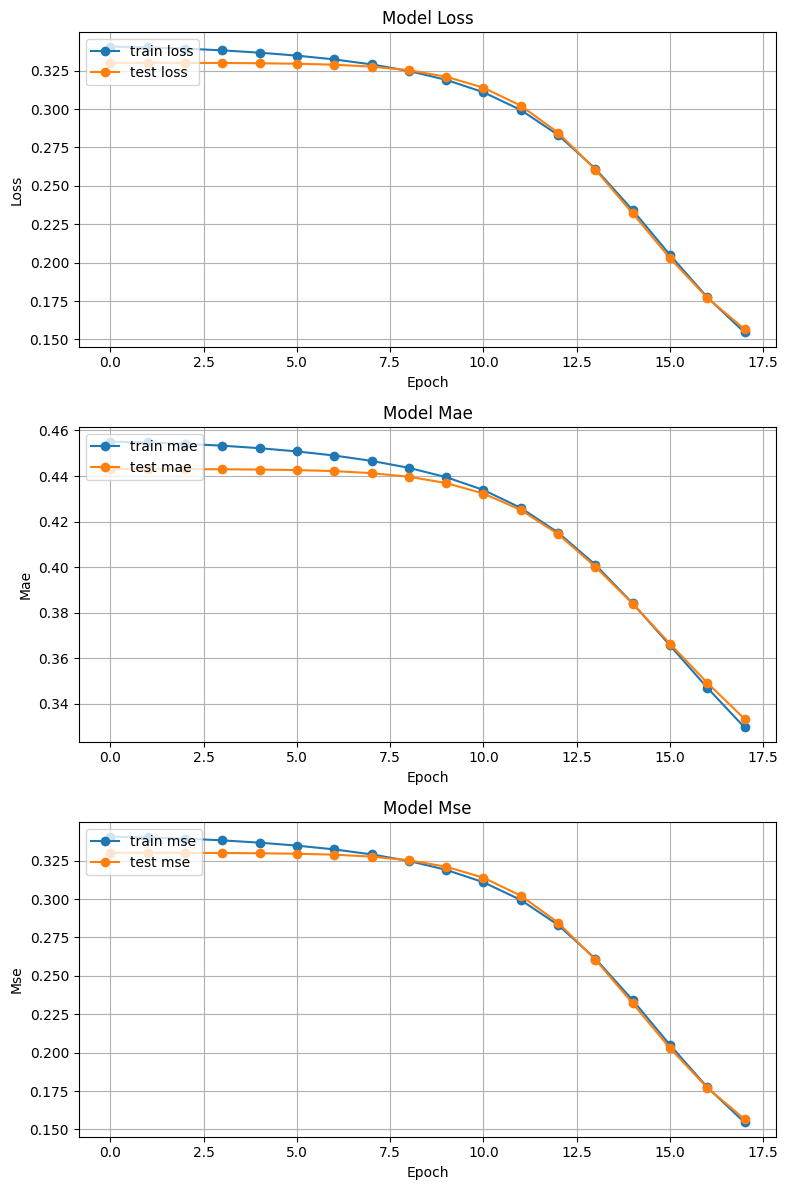

In [89]:
metrics = ["loss", "mae", "mse"]

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) * 4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-2], marker="o", label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-2], marker="o", label=f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [172]:
def extract_weights(name, model, normalize=False):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    if normalize:  # optional flag
        weights = weights / np.linalg.norm(weights, axis=1).reshape((-1, 1))
    return weights

# Use raw embeddings for dot-product similarity
anime_weights = extract_weights("anime_embedding", model, normalize=False)
user_weights  = extract_weights("user_embedding", model, normalize=False)
anime_weights.shape , user_weights.shape

((12791, 128), (1385, 128))

# READING ANIME.CSV

In [93]:
df = pd.read_csv(INPUT_DIR+"/anime.csv",low_memory=True)
df.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [94]:
df = df.replace("Unknown",np.nan)

In [95]:
def getAnimeName(anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]
    except:
        print("Error")
    return name

In [96]:
df["anime_id"] = df["MAL_ID"]
df["eng_version"] = df["English name"]
df["eng_version"] = df.anime_id.apply(lambda x:getAnimeName(x))

In [98]:
getAnimeName(6702)

'Fairy Tail'

In [99]:
df.sort_values(by=["Score"],
               inplace=True,
               ascending=False,
               kind="quicksort",
               na_position="last")

In [100]:
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

In [101]:
df = df[["anime_id" , "eng_version","Score","Genres","Episodes","Type","Premiered","Members"]]

In [102]:
df.head()

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",10,TV,Spring 2019,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",51,TV,Spring 2015,404121


In [103]:
def getAnimeFrame(anime,df):
    if isinstance(anime,int):
        return df[df.anime_id == anime]
    if isinstance(anime,str):
        return df[df.eng_version == anime]
    

In [104]:
getAnimeFrame(40028 , df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260


In [105]:
getAnimeFrame("Steins;Gate",df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162


## ANIME_WITH_SYNOPSIS.CSV

In [106]:
cols = ["MAL_ID","Name","Genres","sypnopsis"]

In [ ]:
synopsis_df = pd.read_csv(INPUT_DIR+"/anime_with_synopsis.csv",usecols=cols)

In [108]:
synopsis_df.head(2)

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."


In [109]:
synopsis_df.columns

Index(['MAL_ID', 'Name', 'Genres', 'sypnopsis'], dtype='object')

In [110]:
def getSynopsis(anime,synopsis_df):
    if isinstance(anime,int):
        return synopsis_df[synopsis_df.MAL_ID == anime].sypnopsis.values[0]
    if isinstance(anime,str):
        return synopsis_df[synopsis_df.Name == anime].sypnopsis.values[0]
    

In [111]:
getSynopsis(40028 , synopsis_df)

"Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom."

In [112]:
getSynopsis("Steins;Gate",synopsis_df)

'The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective "future gadgets" with fellow lab members: Mayuri Shiina, his air-headed childhood friend, and Hashida Itaru, a perverted hacker nicknamed "Daru." The three pass the time by tinkering with their most promising contraption yet, a machine dubbed the "Phone Microwave," which performs the strange function of morphing bananas into piles of green gel. Though miraculous in itself, the phenomenon doesn\'t provide anything concrete in Okabe\'s search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the Phone Microwave can send emails to the past, altering the flow of history. Adapted from the critically acclaimed visual novel by 5pb. and Nitroplus, Steins;Gate takes Okabe through the depths of scientific theory 

## CONTENT BASED RECOMMENDATION

In [113]:
pd.set_option("max_colwidth",None)

In [114]:
def find_similar_animes(name, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df, n=10, return_dist=False, neg=False):
    # Get the anime_id for the given name
    index = getAnimeFrame(name, df).anime_id.values[0]
    encoded_index = anime2anime_encoded.get(index)

    if encoded_index is None:
        raise ValueError(f"Encoded index not found for anime ID: {index}")

    weights = anime_weights

    # Compute the similarity distances
    dists = np.dot(weights, weights[encoded_index])  # Ensure weights[encoded_index] is a 1D array
    sorted_dists = np.argsort(dists)

    n = n + 1

    # Select closest or farthest based on 'neg' flag
    if neg:
        closest = sorted_dists[:n]
    else:
        closest = sorted_dists[-n:]

    # Return distances and closest indices if requested
    if return_dist:
        return dists, closest

    # Build the similarity array
    SimilarityArr = []
    for close in closest:
        decoded_id = anime2anime_decoded.get(close)
       

       
        anime_frame = getAnimeFrame(decoded_id, df)

        anime_name = anime_frame.eng_version.values[0]
        genre = anime_frame.Genres.values[0]
        similarity = dists[close]
   

        SimilarityArr.append({
            "anime_id": decoded_id,
            "name": anime_name,
            "similarity": similarity,
            "genre": genre,
        })
       

    # Create a DataFrame with results and sort by similarity
    Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
    return Frame[Frame.anime_id != index].drop(['anime_id'], axis=1)


In [115]:
find_similar_animes(
    "Steins;Gate",
    anime_weights,
    anime2anime_encoded,
    anime2anime_decoded,
    df,
    synopsis_df,
)

,name,similarity,genre
9,Code Geass:Lelouch of the Rebellion,0.822181,"Action, Military, Sci-Fi, Super Power, Drama, Mecha, School"
8,Angel Beats!,0.807907,"Action, Comedy, Drama, School, Supernatural"
7,Death Note,0.807171,"Mystery, Police, Psychological, Supernatural, Thriller, Shounen"
6,Fullmetal Alchemist:Brotherhood,0.792064,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
5,Attack on Titan,0.785733,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen"
4,Re:ZERO -Starting Life in Another World-,0.777090,"Psychological, Drama, Thriller, Fantasy"
3,"No Game, No Life",0.775557,"Game, Adventure, Comedy, Supernatural, Ecchi, Fantasy"
2,Code Geass:Lelouch of the Rebellion R2,0.773653,"Action, Military, Sci-Fi, Super Power, Drama, Mecha"
1,Tokyo Ghoul,0.747664,"Action, Mystery, Horror, Psychological, Supernatural, Drama, Seinen"
0,One Punch Man,0.746817,"Action, Sci-Fi, Comedy, Parody, Super Power, Supernatural"


## USER BASED RECOMMENDATION

In [128]:
def find_similar_users(
    user_input, user_weights, user2user_encoded, user2user_decoded,
    n=10, return_dist=False, neg=False
):
    # Encode the input user
    encoded_index = user2user_encoded.get(user_input)
    if encoded_index is None:
        raise ValueError(f"User {user_input} not found in encoded dictionary")

    weights = user_weights

    # Compute cosine similarity (dot product since embeddings are normalized)
    dists = np.dot(weights, weights[encoded_index])
    sorted_dists = np.argsort(dists)

    n = n + 1  # add 1 to exclude the user themselves later

    # Select closest or farthest users
    if neg:
        closest = sorted_dists[:n]
    else:
        closest = sorted_dists[-n:]

    # If caller only wants raw distances
    if return_dist:
        return dists, closest

    # Build similarity list
    SimilarityArr = []
    for close in closest:
        decoded_id = user2user_decoded.get(close)
        similarity = dists[close]

        SimilarityArr.append({
            "user_id": decoded_id,
            "similarity": similarity,
        })

    # Sort by similarity and exclude the original user
    Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
    return Frame[Frame.user_id != user_input]


In [129]:
similar_users = find_similar_users(
    user_input=123,  # your raw user_id
    user_weights=user_weights,
    user2user_encoded=user2user_encoded,
    user2user_decoded=user2user_decoded,
    n=5
)

print(similar_users)


   user_id  similarity
4      781    0.515913
3      890    0.512960
2     1004    0.511206
1     1397    0.506222
0     1483    0.494604


In [131]:
find_similar_users(int(118),user_weights,user2user_encoded,user2user_decoded)

,user_id,similarity
9,418,0.362166
8,883,0.325077
7,1149,0.323774
6,469,0.311333
5,957,0.309990
4,1213,0.309141
3,461,0.306715
2,1016,0.302847
1,21,0.300697
0,320,0.298556


In [132]:
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700,height=400,background_color='white',colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10,8))
    plt.imshow(genres_cloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [133]:
from collections import defaultdict

In [134]:
df.head(1)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",64,TV,Spring 2009,2248456


In [135]:
def getFavGenre(frame , plot=False):
    frame.dropna(inplace=False)
    all_genres = defaultdict(int)

    genres_list = []
    for genres in frame["Genres"]:
        if isinstance(genres,str):
            for genre in genres.split(','):
                genres_list.append(genre)
                all_genres[genre.strip()] += 1

    if plot:
        showWordCloud(all_genres)
    
    return genres_list



In [136]:
rating_df.head(2)

,user_id,anime_id,rating,user,anime
0,1548,5114,0.7,1313,63
1,1596,744,0.0,1357,6947


In [137]:
def get_user_preferences(user_id , rating_df , df ,plot=False):

    animes_watched_by_user = rating_df[rating_df.user_id == user_id]

    user_rating_percentile = np.percentile(animes_watched_by_user.rating , 75)

    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]

    top_animes_user = (
        animes_watched_by_user.sort_values(by="rating" , ascending=False).anime_id.values
    )

    anime_df_rows = df[df["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["eng_version","Genres"]]

    if plot:
        getFavGenre(anime_df_rows,plot)


    return anime_df_rows




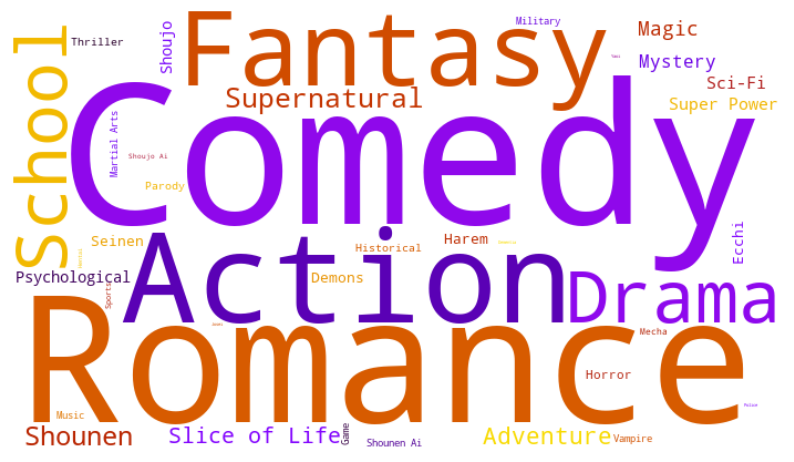

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
15926,Attack on Titan Final Season,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen"
5683,Steins;Gate,"Thriller, Sci-Fi"
14963,Attack on Titan Season 3 Part 2,"Action, Drama, Fantasy, Military, Mystery, Shounen, Super Power"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
...,...,...
17409,Dungeon ni Deai wo Motomeru no wa Machigatteiru Darou ka III OVA,"Adventure, Comedy, Romance, Ecchi, Fantasy"
17424,Aggressive Retsuko (ONA) 4th Season,"Slice of Life, Comedy"
17473,Nanatsu no Taizai Movie 2: Hikari ni Norowareshi Mono-tachi,"Action, Adventure, Supernatural, Magic, Fantasy, Shounen"
17494,Goblin Slayer 2nd Season,"Action, Adventure, Fantasy"


In [138]:
get_user_preferences(500, rating_df, df , plot=True)

In [151]:
def get_user_recommendations(similar_users, user_pref, df, synopsis_df, rating_df, n=1):
    recommended_animes = []
    anime_list = []

    # iterate over similar users
    for user_id in similar_users.user_id.values:
        pref_list = get_user_preferences(int(user_id), rating_df, df)

        # remove animes the target user already watched
        pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]

        # collect candidate animes
        anime_list.extend(pref_list.eng_version.values)

    # count frequency of each anime among similar users
    anime_counts = pd.Series(anime_list).value_counts()

    # pick top-n recommendations
    top_animes = anime_counts.head(n).index.tolist()

    # merge with metadata
    recommended_animes = df[df.eng_version.isin(top_animes)].merge(
        synopsis_df, on="anime_id", how="left"
    )

    return recommended_animes


In [146]:
similar_users =find_similar_users(int(880),user_weights,user2user_encoded,user2user_decoded)

In [149]:
user_pref = get_user_preferences(880 , rating_df, df , plot=False)

In [152]:
similar_users = find_similar_users(int(880), user_weights, user2user_encoded, user2user_decoded)
user_pref = get_user_preferences(880, rating_df, df, plot=False)
synopsis_df = synopsis_df.rename(columns={"MAL_ID": "anime_id"})  # crucial fix
get_user_recommendations(similar_users, user_pref, df, synopsis_df, rating_df, n=1)


,anime_id,eng_version,Score,Genres_x,Episodes,Type,Premiered,Members,Name,Genres_y,sypnopsis
0,12365,Bakuman.,8.58,"Comedy, Drama, Romance, Shounen",25,TV,Fall 2012,268794,Bakuman. 3rd Season,"Comedy, Drama, Romance, Shounen","Onto their third serialization, manga duo Moritaka Mashiro and Akito Takagi—also known by their pen name, Muto Ashirogi—are ever closer to their dream of an anime adaption. However, the real challenge is only just beginning: if they are unable to compete with the artist Eiji Niizuma in the rankings within the span of six months, they will be canceled. To top it off, numerous rivals are close behind and declaring war. They don't even have enough time to spare thinking about an anime! In Bakuman. 3rd Season , Muto Ashirogi must find a way to stay atop the colossal mountain known as the Shounen Jack rankings. With new problems and new assistants, the pair continue to strive for their dream."
1,10030,Bakuman.,8.4,"Comedy, Drama, Romance, Shounen",25,TV,Fall 2011,289356,Bakuman. 2nd Season,"Comedy, Drama, Romance, Shounen","h the serialization of their new manga, ""Detective Trap,"" the writer-artist team, Akito Takagi and Moritaka Mashiro, better known by their pseudonym Muto Ashirogi, are one step closer to becoming world-renowned mangaka. For Mashiro, however, serialization is just the first step. Having promised to marry his childhood sweetheart and aspiring voice actress, Azuki Miho, once his manga gets an anime adaptation, Mashiro must continue his to popularize Ashirogi's work. A tremendously competitive cast of ambitious mangaka—including the wild genius, Eiji Niizuma; the elegant student, Yuriko Aoki, and her older admirer and partner, Takurou Nakai; the lazy prodigy, Kazuya Hiramaru; and the abrasive artist, Shinta Fukuda—both support and compete against Muto Ashirogi in creating the next big hit. As they adjust to their young and seemingly untested new editor, the dynamic duo struggle to maintain their current serialization, secure the top stop in Shounen Jack, and ultimately, achieve an anime adaptation of their manga. With new rivals and friends, Bakuman. 2nd Season continues Takagi and Mashiro's inspiring story of hard work and young love."
2,7674,Bakuman.,8.23,"Comedy, Drama, Romance, Shounen",25,TV,Fall 2010,490554,Bakuman.,"Comedy, Drama, Romance, Shounen","s a child, Moritaka Mashiro dreamt of becoming a mangaka, just like his childhood hero and uncle, Tarou Kawaguchi, creator of a popular gag manga. But when tragedy strikes, he gives up on his dream and spends his middle school days studying, aiming to become a salaryman instead. One day, his classmate Akito Takagi, the school's top student and aspiring writer, notices the detailed drawings in Moritaka's notebook. Seeing the vast potential of his artistic talent, Akito approaches Moritaka, proposing that they become mangaka together. After much convincing, Moritaka realizes that if he is able to create a popular manga series, he may be able to get the girl he has a crush on, Miho Azuki, to take part in the anime adaptation as a voice actor. Thus the pair begins creating manga under the pen name Muto Ashirogi, hoping to become the greatest mangaka in Japan, the likes of which no one has ever seen."


In [164]:
def get_anime_id_by_name(anime_name, df):
    match = df[df["eng_version"].str.lower() == anime_name.lower()]
    if match.empty:
        return None
    return match.iloc[0]["anime_id"]


In [170]:
def recommend_by_anime_name(anime_name, df, synopsis_df, rating_df, n=5):
    # Ensure merge key matches
    synopsis_df = synopsis_df.rename(columns={"MAL_ID": "anime_id"})
    
    # Step 1: Find anime_id from name
    anime_row = df[df["eng_version"].str.lower() == anime_name.lower()]
    if anime_row.empty:
        return f"❌ Anime '{anime_name}' not found in dataset."
    anime_id = anime_row.iloc[0]["anime_id"]

    # Step 2: Find users who rated this anime
    users_who_watched = rating_df[rating_df["anime_id"] == anime_id]["user_id"].unique()
    if len(users_who_watched) == 0:
        return f"⚠️ No users found who watched '{anime_name}'."

    # Step 3: Collect other animes those users liked
    other_animes = rating_df[rating_df["user_id"].isin(users_who_watched)]
    other_animes = other_animes[other_animes["anime_id"] != anime_id]

    # Step 4: Count frequency (like your original function)
    anime_counts = other_animes["anime_id"].value_counts().head(n).index.tolist()

    # Step 5: Fetch details
    recommendations = df[df["anime_id"].isin(anime_counts)].merge(
        synopsis_df, on="anime_id", how="left"
    )

    return recommendations[["eng_version", "Genres", "Score", "Synopsis"]]


In [178]:
def recommend_by_anime_name(anime_name, df, synopsis_df, rating_df, user_weights, anime_weights, user2user_encoded, anime2anime_encoded, anime2anime_decoded, n=5):
    synopsis_df = synopsis_df.rename(columns={"MAL_ID": "anime_id"})

    # Step 1: Find anime_id
    anime_row = df[df["eng_version"].str.lower() == anime_name.lower()]
    if anime_row.empty:
        return f"❌ Anime '{anime_name}' not found in dataset."
    anime_id = anime_row.iloc[0]["anime_id"]

    # Step 2: Find users who watched this anime
    users_who_watched = rating_df[rating_df["anime_id"] == anime_id]["user_id"].unique()
    if len(users_who_watched) == 0:
        return f"⚠️ No users found who watched '{anime_name}'."

    # Step 3: Pick one "representative" user (e.g., the first one)
    rep_user = users_who_watched[0]
    if rep_user not in user2user_encoded:
        return f"⚠️ User {rep_user} not in encoded mapping."

    encoded_user = user2user_encoded[rep_user]
    user_vector = user_weights[encoded_user]

    # Step 4: Predict scores for all animes
    scores = np.dot(anime_weights, user_vector)

    # Step 5: Rank top-n animes (excluding the input one)
    top_indices = np.argsort(-scores)
    top_animes = []
    for idx in top_indices:
        aid = anime2anime_decoded[idx]
        if aid != anime_id:
            top_animes.append(aid)
        if len(top_animes) >= n:
            break

    # Step 6: Fetch details
    recommendations = df[df["anime_id"].isin(top_animes)].merge(
        synopsis_df, on="anime_id", how="left"
    )

    cols = ["eng_version", "Score"]
    if "Genres" in recommendations.columns:
        cols.append("Genres")
    if "Synopsis" in recommendations.columns:
        cols.append("Synopsis")
    elif "synopsis" in recommendations.columns:
        cols.append("synopsis")

    return recommendations[cols]


In [182]:
# Example calls with your model variables
anime_name = "Naruto"
print("Recommendations for Naruto:")
print(recommend_by_anime_name(
    anime_name, 
    df, synopsis_df, rating_df, 
    user_weights, anime_weights, 
    user2user_encoded, anime2anime_encoded, anime2anime_decoded, 
    n=5
))

print("\nRecommendations for Death Note:")
print(recommend_by_anime_name(
    "Death Note", 
    df, synopsis_df, rating_df, 
    user_weights, anime_weights, 
    user2user_encoded, anime2anime_encoded, anime2anime_decoded, 
    n=5
))

print("\nRecommendations for One Piece:")
print(recommend_by_anime_name(
    "One Piece", 
    df, synopsis_df, rating_df, 
    user_weights, anime_weights, 
    user2user_encoded, anime2anime_encoded, anime2anime_decoded, 
    n=5
))


Recommendations for Naruto:
                              eng_version Score
0  Code Geass:Lelouch of the Rebellion R2  8.91
1                           Spirited Away  8.83
2                              Death Note  8.63
3                    Parasyte -the maxim-   8.4
4                        Sword Art Online  7.25

Recommendations for Death Note:
                              eng_version Score
0         Fullmetal Alchemist:Brotherhood  9.19
1                         Hunter x Hunter   9.1
2                              Your Name.  8.96
3  Code Geass:Lelouch of the Rebellion R2  8.91
4                         Attack on Titan  8.48

Recommendations for One Piece:
                              eng_version Score
0  Code Geass:Lelouch of the Rebellion R2  8.91
1                    Parasyte -the maxim-   8.4
2                          Akame ga Kill!  7.53
3                        Sword Art Online  7.25
4                     Sword Art Online II  6.79


In [192]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np


In [200]:
# Align synopsis_df with df
synopsis_aligned = df[['anime_id']].merge(synopsis_df[['anime_id', 'sypnopsis']], on='anime_id', how='left')

# Fill missing synopsis
synopsis_aligned['sypnopsis'] = synopsis_aligned['sypnopsis'].fillna('')

# Precompute TF-IDF
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(synopsis_aligned['sypnopsis'])

def recommend_by_anime_name_hybrid(anime_name, df, synopsis_df, rating_df,
                                   user_weights, anime_weights, 
                                   user2user_encoded, anime2anime_encoded, 
                                   anime2anime_decoded, n=5, alpha=0.7):
    """
    Hybrid anime recommendation (embedding + content similarity)
    """
    # Step 1: Find anime ID
    if anime_name not in df['eng_version'].values:
        print(f"{anime_name} not found in dataset!")
        return pd.DataFrame()
    
    anime_id = df.loc[df['eng_version'] == anime_name, 'anime_id'].values[0]
    
    # Step 2: Embedding similarity
    anime_idx = anime2anime_encoded[anime_id]
    embedding_sims = cosine_similarity(anime_weights, anime_weights[anime_idx].reshape(1, -1)).flatten()
    
    # Step 3: Content similarity (synopsis)
    # Find the index in the aligned TF-IDF matrix
    tfidf_idx = synopsis_aligned.index[synopsis_aligned['anime_id'] == anime_id][0]
    content_sims = cosine_similarity(tfidf_matrix, tfidf_matrix[tfidf_idx]).flatten()
    
    # Step 4: Make sure lengths match
    min_len = min(len(embedding_sims), len(content_sims))
    embedding_sims = embedding_sims[:min_len]
    content_sims = content_sims[:min_len]
    
    # Step 5: Combine similarities
    hybrid_sims = alpha * embedding_sims + (1 - alpha) * content_sims
    
    # Step 6: Top N recommendations excluding input anime
    top_idx = hybrid_sims.argsort()[::-1]
    top_idx = [i for i in top_idx if df.iloc[i]['anime_id'] != anime_id][:n]
    
    recommendations = df.iloc[top_idx].copy()
    recommendations['Score'] = rating_df.loc[recommendations['anime_id'], 'rating'].values
    recommendations = recommendations[['eng_version', 'Score']].reset_index(drop=True)
    
    return recommendations

In [201]:
anime_name = "Naruto"
print("Hybrid Recommendations for Naruto:")
print(recommend_by_anime_name_hybrid(
    anime_name, df, synopsis_df, rating_df,
    user_weights, anime_weights, 
    user2user_encoded, anime2anime_encoded, anime2anime_decoded,
    n=5,
    alpha=0.7
))


Hybrid Recommendations for Naruto:
                                        eng_version  Score
0  Made in Abyss Movie 3: Fukaki Tamashii no Reimei    0.0
1                           Ping Pong the Animation    0.0
2                              Land of the Lustrous    0.6
3                         Beck:Mongolian Chop Squad    0.6
4              JoJo's Bizarre Adventure:Golden Wind    0.8


In [188]:
print(synopsis_df.columns)


Index(['anime_id', 'Name', 'Genres', 'sypnopsis'], dtype='object')
